## How good is captrap at actually getting 5' complete molecules?

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
import matplotlib.pyplot as plt
import yaml
from snakemake.io import expand
import pyranges as pr

p = os.path.dirname(os.getcwd())
sys.path.append(p)

from scripts.utils import *
from scripts.vcf_utils import *
from scripts.plotting import *

In [2]:
from plotnine import theme_minimal, theme, element_blank, element_text, element_rect, \
    ggplot, geom_point, aes, stat_smooth, facet_wrap, scale_fill_manual, scale_color_manual, \
    geom_boxplot, geom_sina, element_line, geom_jitter, labs, geom_histogram, \
    scale_y_continuous

In [3]:
def my_theme(base_size=11, w=4, h=3):
    """
    Custom plotnine theme with:
    - White background
    - Clean styling
    - Axes and ticks retained

    Parameters:
    - base_size: Base font size

    Returns:
    - plotnine.theme object
    """
    return (
        theme_minimal(base_size=base_size)
        + theme(
            # White background
            panel_background=element_rect(fill='white', color=None),
            plot_background=element_rect(fill='white', color=None),

            # Remove grid lines
            panel_grid_major=element_blank(),
            panel_grid_minor=element_blank(),
            panel_border=element_blank(),

            # Keep axis lines & ticks (don't blank them)
            axis_line=element_line(color='black'),
            axis_ticks=element_line(color='black'),

            plot_title=element_text(hjust=0.5, family='Helvetica'),
            axis_title_x=element_text(hjust=0.5, family='Helvetica'),
            axis_title_y=element_text(hjust=0.5, margin={'t':0, 'r':-2, 'b':0, 'l':0}, family='Helvetica'),
            
            # Styling text
            legend_title=element_blank(),
            axis_title=element_text(size=base_size + 1, family='Helvetica'),
            legend_text=element_text(size=base_size-2, family='Helvetica'),
            axis_text=element_text(size=base_size, color='black', family='Helvetica'),
            figure_size=(w, h),  # Controls plot dimensions (width x height in inches)
            plot_margin=0.05      # Shrinks surrounding white space
        )
    )

In [4]:
config = load_config()
od = '../'

def proc_cfg(entry, od):
    entry = entry.replace('../../', '')
    entry = od+entry
    return entry

In [5]:
f = proc_cfg(config['lr']['tss_pls_int_count_summary'], od)
df = pd.read_csv(f, sep='\t')
df = df.loc[df.int_pls==True]
meta = load_meta()
df = df.merge(meta[['sample', 'population']], 
              how='left',
              on='sample')

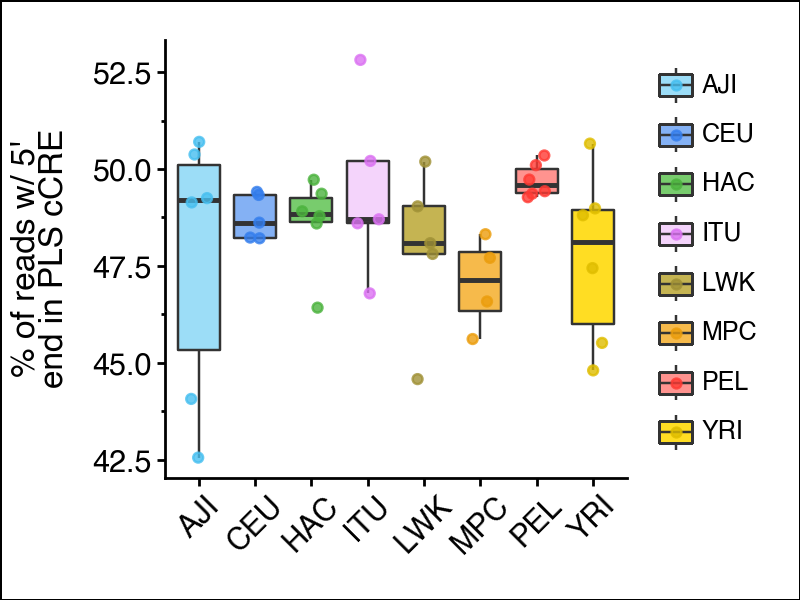

In [6]:
from matplotlib.colors import to_rgb, to_hex
import colorsys

c_dict, order = get_population_colors()

def mute_color(hex_color, factor=1.4):
    """Lighten a hex color by increasing its lightness in HLS space."""
    r, g, b = to_rgb(hex_color)
    h, l, s = colorsys.rgb_to_hls(r, g, b)
    l = min(1.0, l * factor)  # Lighten
    r_muted, g_muted, b_muted = colorsys.hls_to_rgb(h, l, s)
    return to_hex((r_muted, g_muted, b_muted))

muted_c_dict = {k: mute_color(v, factor=1.3) for k, v in c_dict.items()}
df['population'] = pd.Categorical(df['population'], categories=order, ordered=True)

(ggplot(df, aes('population', 'perc_reads'))
     + geom_boxplot(aes(fill='population'), outlier_shape=None, outlier_alpha=0)
     # + geom_sina(aes(x='Name', y='n_var_pos', color='population'))
     + geom_jitter(aes(color='population'), width=0.2, size=1.5, alpha=0.8)
     + scale_fill_manual(values=muted_c_dict)
     + scale_color_manual(values=c_dict)
     + labs(
        y="% of reads w/ 5'\nend in PLS cCRE",
        x='')
     + my_theme()
     + theme(axis_text_x=element_text(rotation=45))
)

In [7]:
# HPRC
f = proc_cfg(config['hprc']['kinnex']['map']['tss_pls_int_count_summary'], od)
df = pd.read_csv(f, sep='\t')
df = df.loc[df.int_pls==True]
meta = pd.read_csv('../snakemake/hprc/kinnex_metadata_2.tsv', sep='\t')
meta = meta[['sample_id', 'population', 'Superpopulation']].drop_duplicates()
meta.rename({'sample_id':'sample'}, axis=1, inplace=True)
df = df.merge(meta, how='left', on='sample')

In [8]:
df.head()

,Unnamed: 0,int_pls,n_reads,n_total_reads,perc_reads,sample,population,Superpopulation
0,1,True,4148447,12069983,34.369949,HG00423,CHS,EAS
1,1,True,4148447,12069983,34.369949,HG00423,CHS,EAS
2,1,True,4577426,14244832,32.133942,HG00438,CHS,EAS
3,1,True,4577426,14244832,32.133942,HG00438,CHS,EAS
4,1,True,4945240,15531560,31.839944,HG00621,CHS,EAS


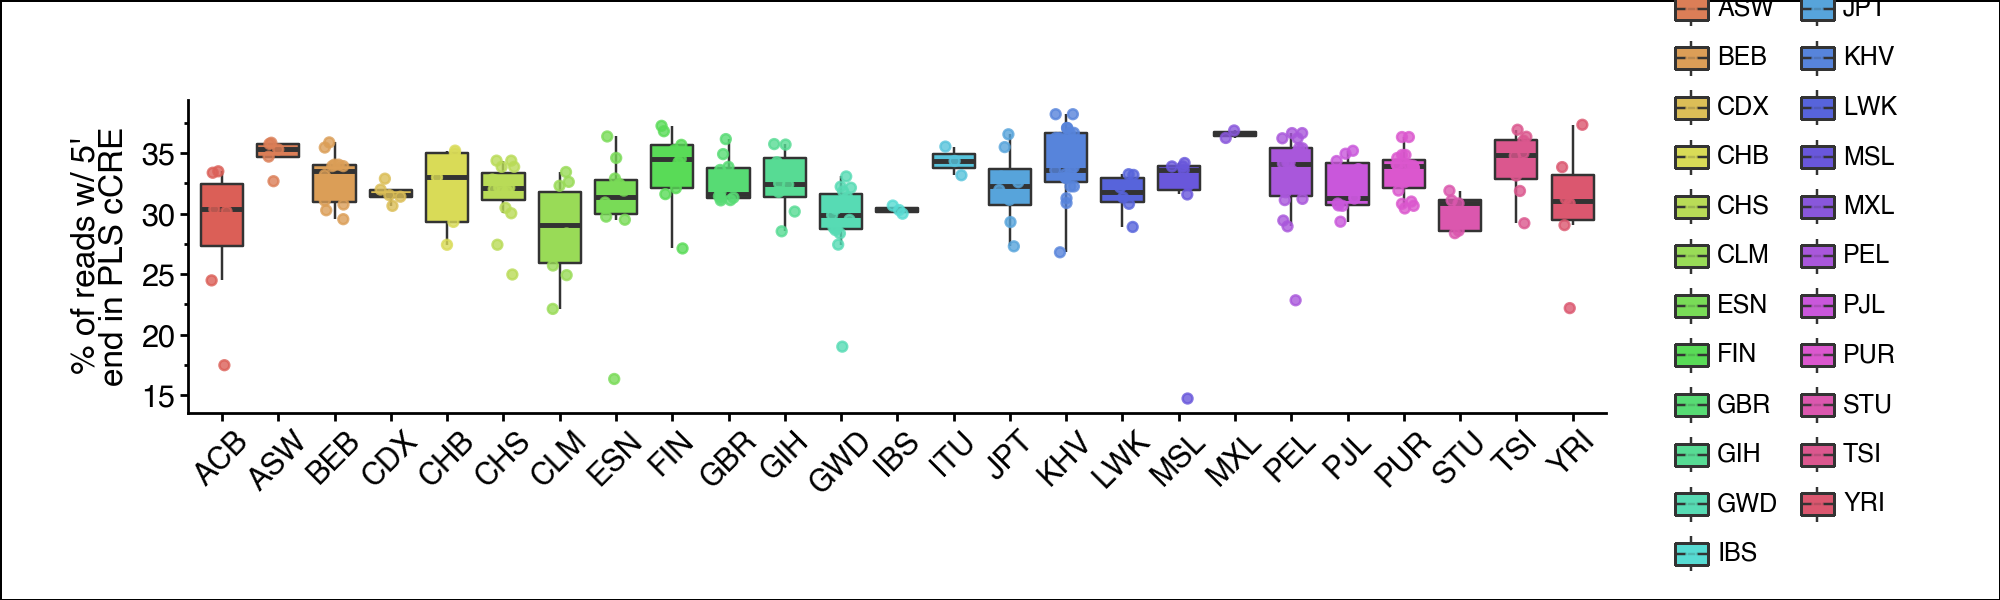

In [9]:
(ggplot(df, aes('population', 'perc_reads'))
     + geom_boxplot(aes(fill='population'), outlier_shape=None, outlier_alpha=0)
     # + geom_sina(aes(x='Name', y='n_var_pos', color='population'))
     + geom_jitter(aes(color='population'), width=0.2, size=1.5, alpha=0.8)
     # + scale_fill_manual(values=muted_c_dict)
     # + scale_color_manual(values=c_dict)
     + labs(
        y="% of reads w/ 5'\nend in PLS cCRE",
        x='')
     + my_theme(w=10)
     + theme(axis_text_x=element_text(rotation=45))
)

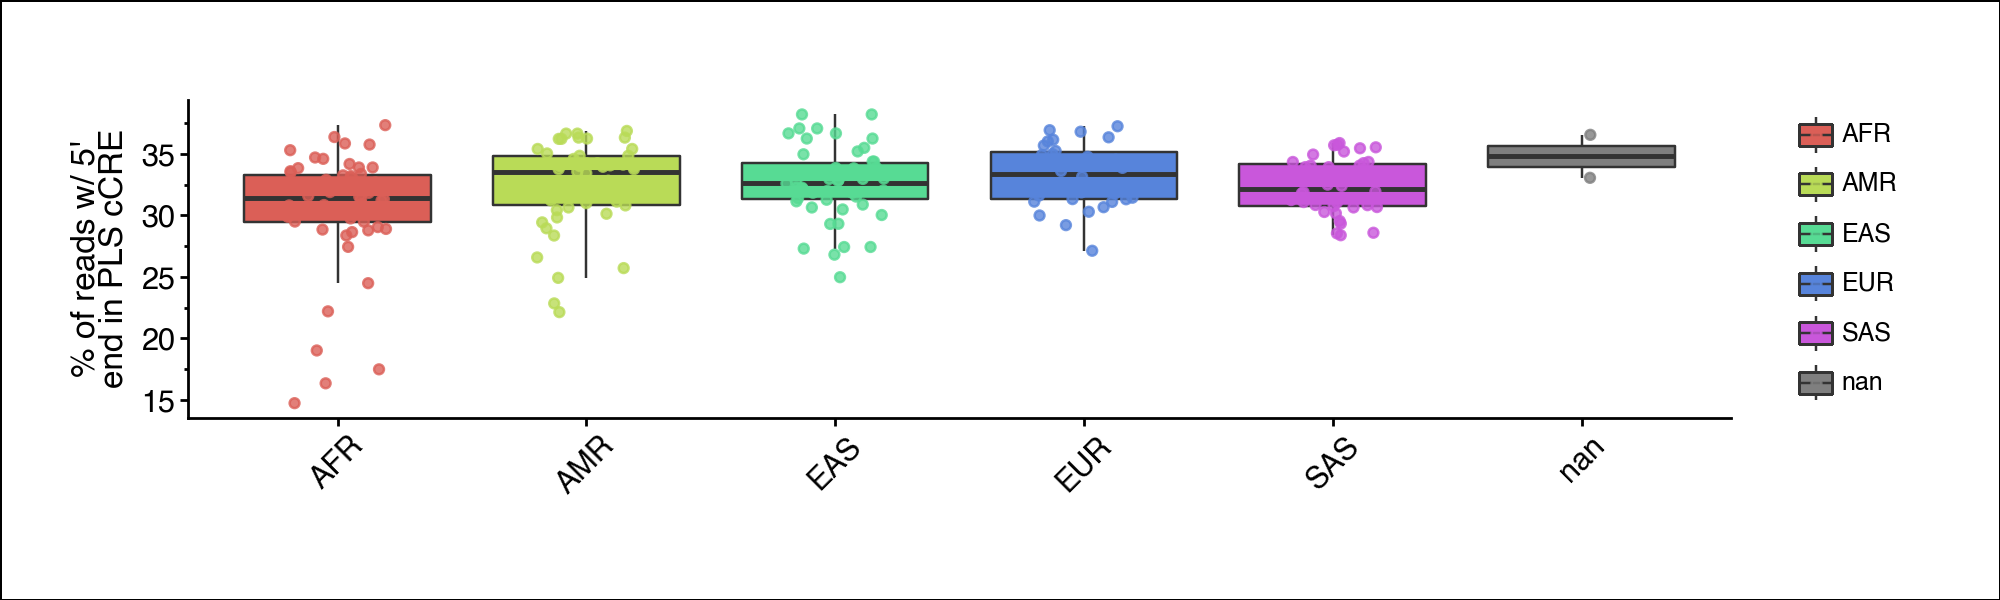

In [10]:
(ggplot(df, aes('Superpopulation', 'perc_reads'))
     + geom_boxplot(aes(fill='Superpopulation'), outlier_shape=None, outlier_alpha=0)
     # + geom_sina(aes(x='Name', y='n_var_pos', color='population'))
     + geom_jitter(aes(color='Superpopulation'), width=0.2, size=1.5, alpha=0.8)
     # + scale_fill_manual(values=muted_c_dict)
     # + scale_color_manual(values=c_dict)
     + labs(
        y="% of reads w/ 5'\nend in PLS cCRE",
        x='')
     + my_theme(w=10)
     + theme(axis_text_x=element_text(rotation=45))
)